In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import imageio
import torchvision.utils as vutils
import matplotlib.pyplot as plt 
import matplotlib.animation as animation

In [3]:
batch_size = 64
num_channels = 1
num_classes = 10
image_size = 28
latent_dim = 128

# download path 정의
download_root = './MNIST_DATASET'

In [4]:
mnist_transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5,), (0.5,))
])

In [5]:
train_dataset = MNIST(download_root, transform=mnist_transform, train=True, download=True)
test_dataset = MNIST(download_root, transform=mnist_transform, train=False, download=True)
train_dataset.data.shape, test_dataset.data.shape, train_dataset.targets.shape, test_dataset.targets.shape

(torch.Size([60000, 28, 28]),
 torch.Size([10000, 28, 28]),
 torch.Size([60000]),
 torch.Size([10000]))

In [6]:
all_dataset = torch.utils.data.ConcatDataset([train_dataset, test_dataset])
train_loader = torch.utils.data.DataLoader(dataset=all_dataset, 
                         batch_size=batch_size,
                         shuffle=True, drop_last=True)
generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes
print(generator_in_channels, discriminator_in_channels)

138 11


In [7]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args[0]

    def forward(self, x):
        return x.view(self.shape)

In [8]:
class Generator(nn.Module) :
    def __init__(self):
        super().__init__()
        self.generator = nn.Sequential(
            nn.Linear(generator_in_channels, 7 * 7 * generator_in_channels),
            nn.LeakyReLU(0.2),
            Reshape((-1, generator_in_channels,7,7)),
            nn.ConvTranspose2d(generator_in_channels, 128, (4,4), (2,2)),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(128, 128, (4,4), (2,2)),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 1, (7,7)),
            nn.Tanh())
    def forward(self, noise, one_hot_labels):
        random_vector_labels = torch.cat(
            (noise, one_hot_labels), 1
        )
        generated_images = self.generator(random_vector_labels)
        return generated_images

In [9]:
class Discriminator(nn.Module) :
    def __init__(self):
        super().__init__()
        self.discriminator = nn.Sequential(
            nn.Conv2d(discriminator_in_channels, 128, (3,3), (2,2)),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 128, (3,3), (2,2)),
            nn.LeakyReLU(0.2),
            nn.AdaptiveMaxPool2d(1),
            nn.Flatten(),
            nn.Linear(128,1))
    def forward(self, images, one_hot_labels):
        image_size = images.shape[2]
        
#         image_one_hot_labels = one_hot_labels[:,:,None,None]
        image_one_hot_labels = one_hot_labels.repeat_interleave(
            torch.tensor(image_size*image_size).to(device)
        )
        image_one_hot_labels = image_one_hot_labels.view(
            (-1, num_classes, image_size, image_size)
        )
#         image_one_hot_labels = image_one_hot_labels.permute(0,3,1,2)
        images_and_labels = torch.cat((images, image_one_hot_labels), 1)
        predictions = self.discriminator(images_and_labels)
        return predictions, images_and_labels

In [10]:
class AverageMeter(object):
    """
    Keeps track of most recent, average, sum, and count of a metric.
    """

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator()
discriminator = Discriminator()
generator = generator.to(device)
discriminator = discriminator.to(device)

d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0003)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0003)
criterion = torch.nn.BCEWithLogitsLoss().to(device)

epochs = 20

In [12]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Linear) :
        torch.nn.init.xavier_uniform_(m.weight)
        torch.nn.init.zeros_(m.bias)

In [13]:
generator.apply(weights_init)
discriminator.apply(weights_init)

Discriminator(
  (discriminator): Sequential(
    (0): Conv2d(11, 128, kernel_size=(3, 3), stride=(2, 2))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
    (3): LeakyReLU(negative_slope=0.2)
    (4): AdaptiveMaxPool2d(output_size=1)
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
)

Epoch: [0][0/1093]	generator_loss: 0.6787 (0.6787)	discriminator_loss: 0.7295 (0.7295)	
Epoch: [0][200/1093]	generator_loss: 6.0676 (4.0669)	discriminator_loss: 0.0021 (0.1075)	
Epoch: [0][400/1093]	generator_loss: 7.2692 (5.4443)	discriminator_loss: 0.0006 (0.0544)	
Epoch: [0][600/1093]	generator_loss: 4.2405 (5.7170)	discriminator_loss: 0.1699 (0.1453)	
Epoch: [0][800/1093]	generator_loss: 1.1132 (4.6762)	discriminator_loss: 0.5892 (0.2215)	
Epoch: [0][1000/1093]	generator_loss: 1.2204 (3.9917)	discriminator_loss: 0.4914 (0.2779)	


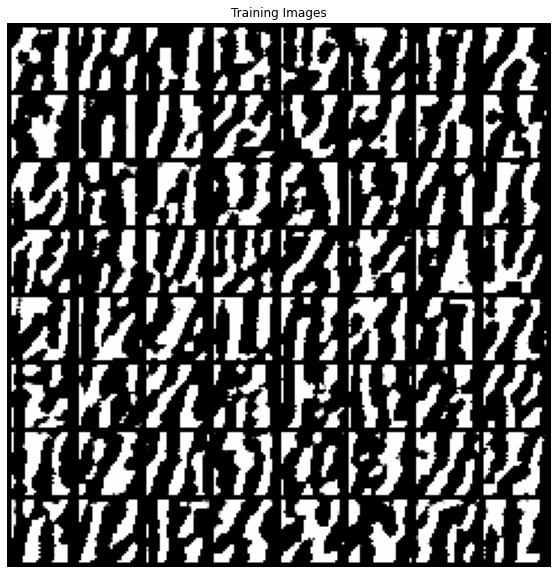

Epoch: [1][0/1093]	generator_loss: 2.2141 (2.2141)	discriminator_loss: 0.2250 (0.2250)	
Epoch: [1][200/1093]	generator_loss: 2.1868 (1.8246)	discriminator_loss: 0.2695 (0.3547)	
Epoch: [1][400/1093]	generator_loss: 1.9363 (2.1597)	discriminator_loss: 0.3035 (0.2916)	
Epoch: [1][600/1093]	generator_loss: 3.2490 (2.3762)	discriminator_loss: 0.1246 (0.2481)	
Epoch: [1][800/1093]	generator_loss: 5.1620 (2.5157)	discriminator_loss: 0.0090 (0.2265)	
Epoch: [1][1000/1093]	generator_loss: 3.1471 (2.8545)	discriminator_loss: 0.0770 (0.2024)	


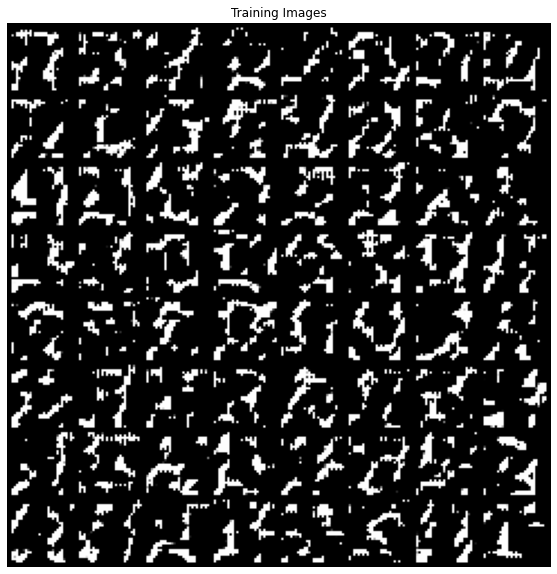

Epoch: [2][0/1093]	generator_loss: 3.4568 (3.4568)	discriminator_loss: 0.1451 (0.1451)	
Epoch: [2][200/1093]	generator_loss: 3.5545 (3.6501)	discriminator_loss: 0.0696 (0.0894)	
Epoch: [2][400/1093]	generator_loss: 4.2763 (3.8092)	discriminator_loss: 0.0544 (0.0776)	
Epoch: [2][600/1093]	generator_loss: 4.4066 (4.0323)	discriminator_loss: 0.0497 (0.0696)	
Epoch: [2][800/1093]	generator_loss: 4.1451 (4.2171)	discriminator_loss: 0.0349 (0.0614)	
Epoch: [2][1000/1093]	generator_loss: 4.4332 (4.3507)	discriminator_loss: 0.0260 (0.0559)	


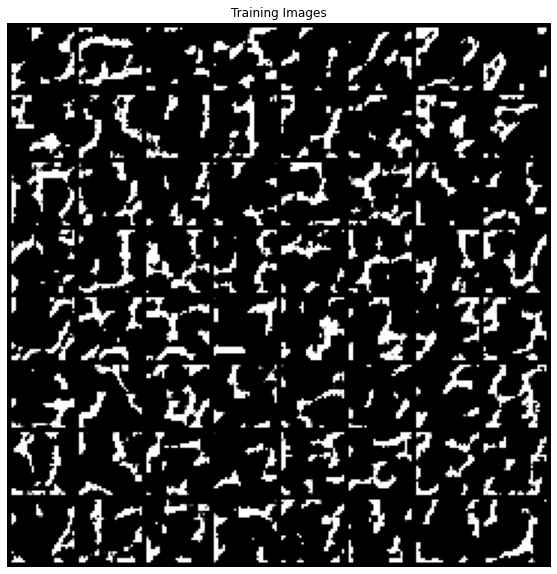

Epoch: [3][0/1093]	generator_loss: 4.6664 (4.6664)	discriminator_loss: 0.0382 (0.0382)	
Epoch: [3][200/1093]	generator_loss: 4.5778 (5.0791)	discriminator_loss: 0.0271 (0.0295)	
Epoch: [3][400/1093]	generator_loss: 5.1570 (4.9574)	discriminator_loss: 0.2172 (0.0431)	
Epoch: [3][600/1093]	generator_loss: 2.2528 (4.0945)	discriminator_loss: 0.3163 (0.1436)	
Epoch: [3][800/1093]	generator_loss: 2.8845 (3.7081)	discriminator_loss: 0.2378 (0.1774)	
Epoch: [3][1000/1093]	generator_loss: 2.4011 (3.4546)	discriminator_loss: 0.3865 (0.1983)	


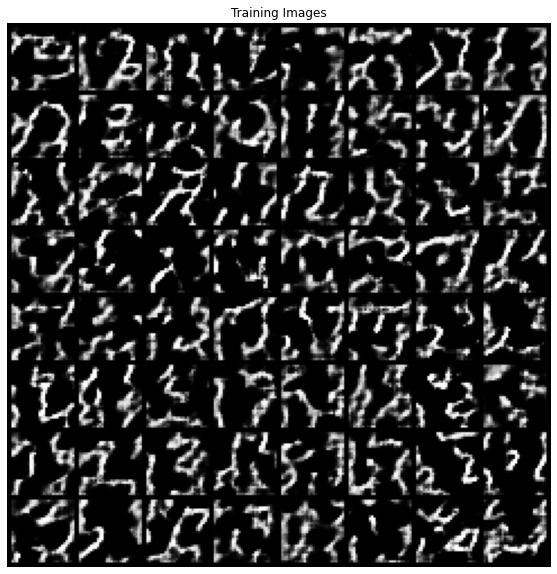

Epoch: [4][0/1093]	generator_loss: 2.2660 (2.2660)	discriminator_loss: 0.3123 (0.3123)	
Epoch: [4][200/1093]	generator_loss: 1.8836 (2.4103)	discriminator_loss: 0.3253 (0.2827)	
Epoch: [4][400/1093]	generator_loss: 2.3413 (2.3200)	discriminator_loss: 0.2699 (0.2971)	
Epoch: [4][600/1093]	generator_loss: 2.1201 (2.2348)	discriminator_loss: 0.3209 (0.3129)	
Epoch: [4][800/1093]	generator_loss: 1.6916 (2.1646)	discriminator_loss: 0.3960 (0.3335)	
Epoch: [4][1000/1093]	generator_loss: 1.2511 (2.0687)	discriminator_loss: 0.5856 (0.3558)	


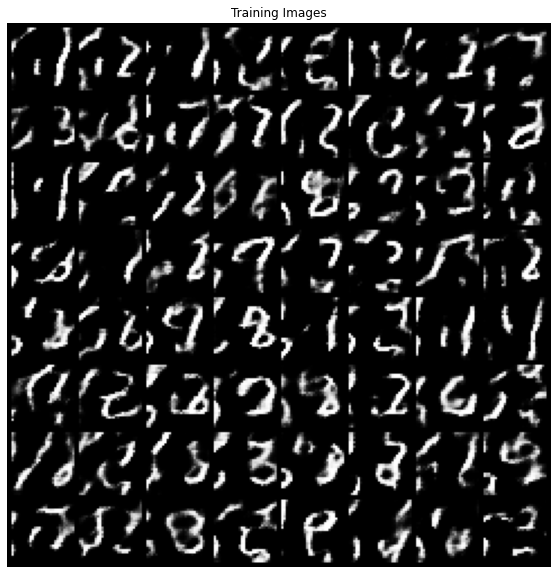

Epoch: [5][0/1093]	generator_loss: 1.6107 (1.6107)	discriminator_loss: 0.4990 (0.4990)	
Epoch: [5][200/1093]	generator_loss: 1.6180 (1.5873)	discriminator_loss: 0.4279 (0.4684)	
Epoch: [5][400/1093]	generator_loss: 1.5138 (1.5457)	discriminator_loss: 0.5417 (0.4773)	
Epoch: [5][600/1093]	generator_loss: 1.3981 (1.5307)	discriminator_loss: 0.5686 (0.4849)	
Epoch: [5][800/1093]	generator_loss: 1.3135 (1.4895)	discriminator_loss: 0.4187 (0.4906)	
Epoch: [5][1000/1093]	generator_loss: 1.5484 (1.4588)	discriminator_loss: 0.5301 (0.4974)	


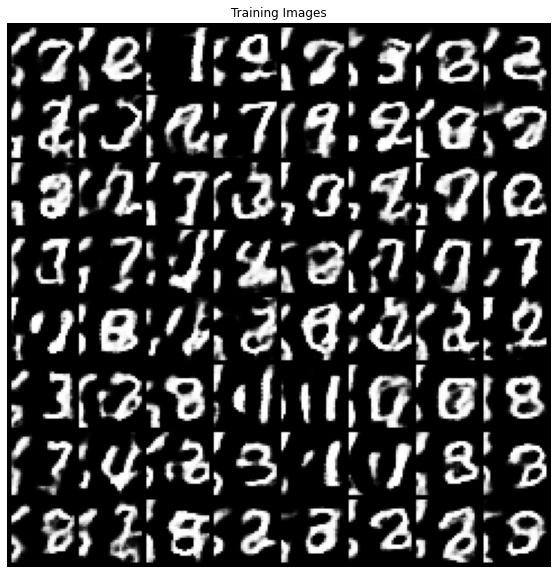

Epoch: [6][0/1093]	generator_loss: 1.1268 (1.1268)	discriminator_loss: 0.7386 (0.7386)	
Epoch: [6][200/1093]	generator_loss: 0.8727 (1.2891)	discriminator_loss: 0.6635 (0.5457)	
Epoch: [6][400/1093]	generator_loss: 1.0120 (1.2893)	discriminator_loss: 0.7085 (0.5456)	
Epoch: [6][600/1093]	generator_loss: 1.1569 (1.2588)	discriminator_loss: 0.5449 (0.5483)	
Epoch: [6][800/1093]	generator_loss: 1.1651 (1.2485)	discriminator_loss: 0.6504 (0.5499)	
Epoch: [6][1000/1093]	generator_loss: 1.0911 (1.2379)	discriminator_loss: 0.5693 (0.5526)	


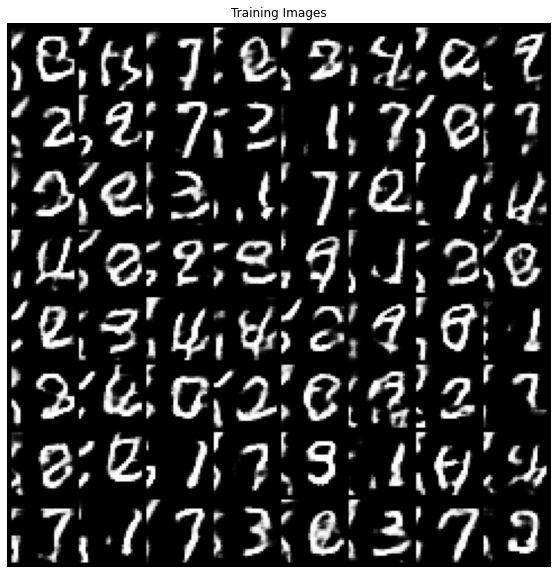

Epoch: [7][0/1093]	generator_loss: 1.2110 (1.2110)	discriminator_loss: 0.4675 (0.4675)	
Epoch: [7][200/1093]	generator_loss: 1.1171 (1.1417)	discriminator_loss: 0.6541 (0.5622)	
Epoch: [7][400/1093]	generator_loss: 1.1462 (1.1798)	discriminator_loss: 0.6853 (0.5611)	
Epoch: [7][600/1093]	generator_loss: 1.3509 (1.1572)	discriminator_loss: 0.4857 (0.5697)	
Epoch: [7][800/1093]	generator_loss: 1.2636 (1.1571)	discriminator_loss: 0.5652 (0.5678)	
Epoch: [7][1000/1093]	generator_loss: 0.9225 (1.1524)	discriminator_loss: 0.5768 (0.5680)	


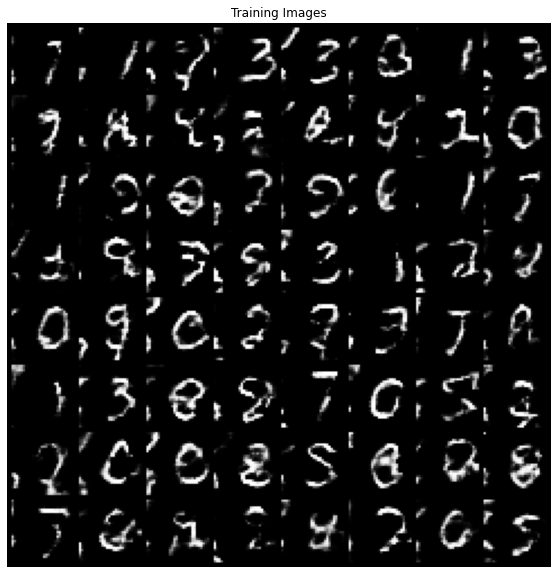

Epoch: [8][0/1093]	generator_loss: 1.5017 (1.5017)	discriminator_loss: 0.4816 (0.4816)	
Epoch: [8][200/1093]	generator_loss: 1.2005 (1.1194)	discriminator_loss: 0.4144 (0.5465)	
Epoch: [8][400/1093]	generator_loss: 1.0426 (1.1279)	discriminator_loss: 0.5292 (0.5599)	
Epoch: [8][600/1093]	generator_loss: 1.1902 (1.1309)	discriminator_loss: 0.5018 (0.5570)	
Epoch: [8][800/1093]	generator_loss: 1.0268 (1.1326)	discriminator_loss: 0.5553 (0.5598)	
Epoch: [8][1000/1093]	generator_loss: 1.1698 (1.1279)	discriminator_loss: 0.7492 (0.5617)	


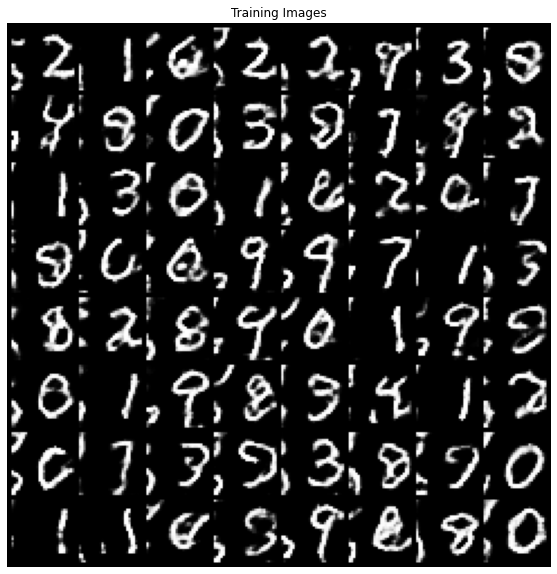

Epoch: [9][0/1093]	generator_loss: 1.0305 (1.0305)	discriminator_loss: 0.5387 (0.5387)	
Epoch: [9][200/1093]	generator_loss: 1.3308 (1.0865)	discriminator_loss: 0.4751 (0.5663)	
Epoch: [9][400/1093]	generator_loss: 1.3920 (1.1105)	discriminator_loss: 0.5232 (0.5677)	
Epoch: [9][600/1093]	generator_loss: 1.1008 (1.1103)	discriminator_loss: 0.4931 (0.5685)	
Epoch: [9][800/1093]	generator_loss: 1.2299 (1.1183)	discriminator_loss: 0.5441 (0.5641)	
Epoch: [9][1000/1093]	generator_loss: 0.8755 (1.1158)	discriminator_loss: 0.5475 (0.5666)	


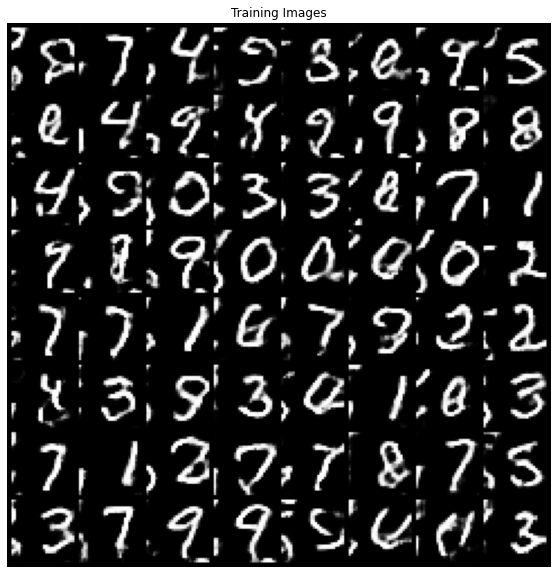

Epoch: [10][0/1093]	generator_loss: 1.1014 (1.1014)	discriminator_loss: 0.5761 (0.5761)	
Epoch: [10][200/1093]	generator_loss: 1.3159 (1.1184)	discriminator_loss: 0.4477 (0.5556)	
Epoch: [10][400/1093]	generator_loss: 1.1734 (1.1387)	discriminator_loss: 0.5084 (0.5544)	
Epoch: [10][600/1093]	generator_loss: 0.8515 (1.1226)	discriminator_loss: 0.5880 (0.5514)	
Epoch: [10][800/1093]	generator_loss: 0.8306 (1.1127)	discriminator_loss: 0.5602 (0.5526)	
Epoch: [10][1000/1093]	generator_loss: 1.4134 (1.1166)	discriminator_loss: 0.3994 (0.5496)	


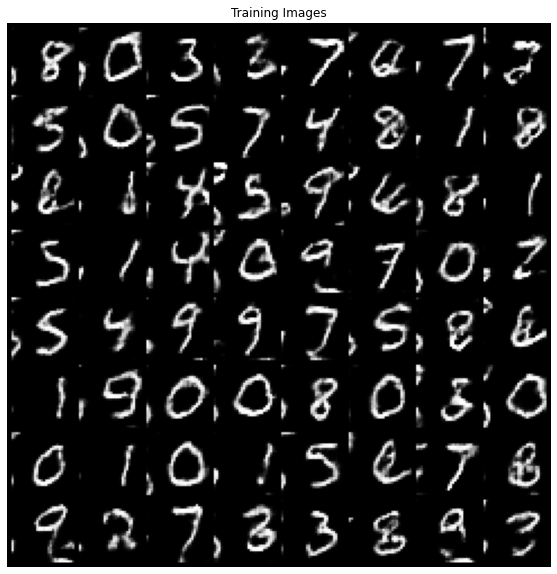

Epoch: [11][0/1093]	generator_loss: 0.8693 (0.8693)	discriminator_loss: 0.7799 (0.7799)	
Epoch: [11][200/1093]	generator_loss: 1.3435 (1.1160)	discriminator_loss: 0.5051 (0.5585)	
Epoch: [11][400/1093]	generator_loss: 1.0641 (1.1065)	discriminator_loss: 0.5519 (0.5555)	
Epoch: [11][600/1093]	generator_loss: 1.2075 (1.1152)	discriminator_loss: 0.5629 (0.5540)	
Epoch: [11][800/1093]	generator_loss: 1.1264 (1.1142)	discriminator_loss: 0.6310 (0.5505)	
Epoch: [11][1000/1093]	generator_loss: 1.0003 (1.1056)	discriminator_loss: 0.5539 (0.5527)	


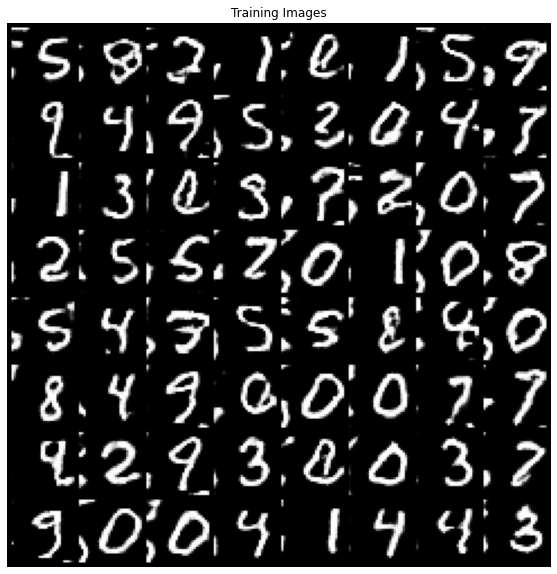

Epoch: [12][0/1093]	generator_loss: 1.0575 (1.0575)	discriminator_loss: 0.5093 (0.5093)	
Epoch: [12][200/1093]	generator_loss: 1.1848 (1.1093)	discriminator_loss: 0.6449 (0.5440)	
Epoch: [12][400/1093]	generator_loss: 1.0305 (1.1034)	discriminator_loss: 0.4927 (0.5505)	
Epoch: [12][600/1093]	generator_loss: 1.1193 (1.0980)	discriminator_loss: 0.5933 (0.5518)	
Epoch: [12][800/1093]	generator_loss: 0.8039 (1.0972)	discriminator_loss: 0.5655 (0.5534)	
Epoch: [12][1000/1093]	generator_loss: 1.0306 (1.1028)	discriminator_loss: 0.7658 (0.5542)	


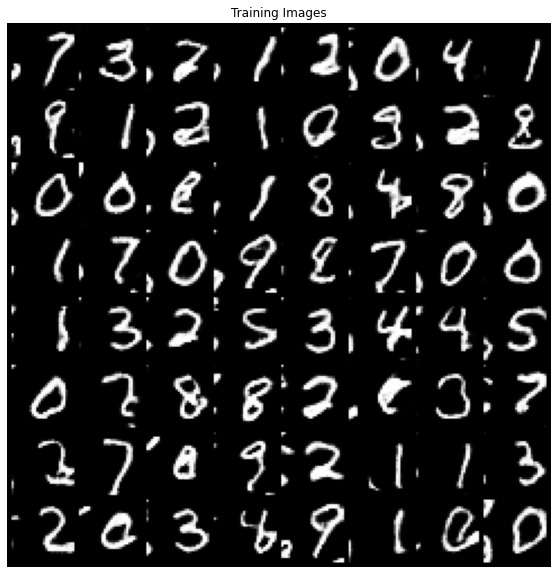

Epoch: [13][0/1093]	generator_loss: 1.0710 (1.0710)	discriminator_loss: 0.5500 (0.5500)	
Epoch: [13][200/1093]	generator_loss: 1.0214 (1.0850)	discriminator_loss: 0.5703 (0.5531)	
Epoch: [13][400/1093]	generator_loss: 1.1170 (1.0773)	discriminator_loss: 0.5881 (0.5581)	
Epoch: [13][600/1093]	generator_loss: 0.9218 (1.0775)	discriminator_loss: 0.6685 (0.5593)	
Epoch: [13][800/1093]	generator_loss: 0.9119 (1.0772)	discriminator_loss: 0.6338 (0.5591)	
Epoch: [13][1000/1093]	generator_loss: 1.1122 (1.0781)	discriminator_loss: 0.5332 (0.5605)	


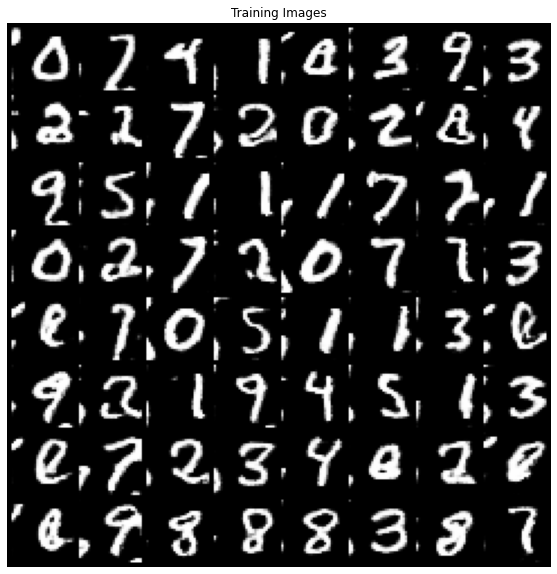

Epoch: [14][0/1093]	generator_loss: 1.1499 (1.1499)	discriminator_loss: 0.4979 (0.4979)	
Epoch: [14][200/1093]	generator_loss: 1.0346 (1.1007)	discriminator_loss: 0.5170 (0.5587)	
Epoch: [14][400/1093]	generator_loss: 1.1106 (1.0774)	discriminator_loss: 0.5352 (0.5597)	
Epoch: [14][600/1093]	generator_loss: 1.1473 (1.0624)	discriminator_loss: 0.5918 (0.5587)	
Epoch: [14][800/1093]	generator_loss: 1.1506 (1.0740)	discriminator_loss: 0.4867 (0.5598)	
Epoch: [14][1000/1093]	generator_loss: 0.9839 (1.0737)	discriminator_loss: 0.5889 (0.5616)	


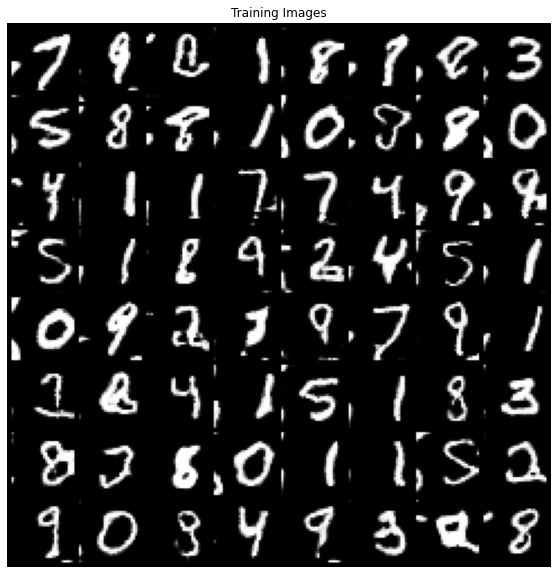

Epoch: [15][0/1093]	generator_loss: 0.9785 (0.9785)	discriminator_loss: 0.5508 (0.5508)	
Epoch: [15][200/1093]	generator_loss: 1.1200 (1.0723)	discriminator_loss: 0.5059 (0.5664)	
Epoch: [15][400/1093]	generator_loss: 0.9674 (1.0607)	discriminator_loss: 0.5618 (0.5677)	
Epoch: [15][600/1093]	generator_loss: 1.2393 (1.0574)	discriminator_loss: 0.5625 (0.5661)	
Epoch: [15][800/1093]	generator_loss: 1.1170 (1.0548)	discriminator_loss: 0.5550 (0.5660)	
Epoch: [15][1000/1093]	generator_loss: 1.0583 (1.0534)	discriminator_loss: 0.5251 (0.5663)	


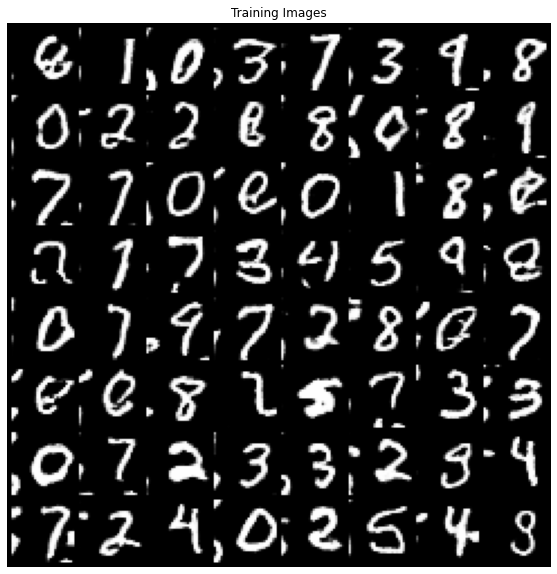

Epoch: [16][0/1093]	generator_loss: 0.7672 (0.7672)	discriminator_loss: 0.5839 (0.5839)	
Epoch: [16][200/1093]	generator_loss: 0.9602 (1.0207)	discriminator_loss: 0.5668 (0.5679)	
Epoch: [16][400/1093]	generator_loss: 1.0947 (1.0346)	discriminator_loss: 0.5413 (0.5641)	
Epoch: [16][600/1093]	generator_loss: 1.0307 (1.0470)	discriminator_loss: 0.6332 (0.5635)	
Epoch: [16][800/1093]	generator_loss: 0.9688 (1.0522)	discriminator_loss: 0.5589 (0.5639)	
Epoch: [16][1000/1093]	generator_loss: 1.0398 (1.0554)	discriminator_loss: 0.5778 (0.5651)	


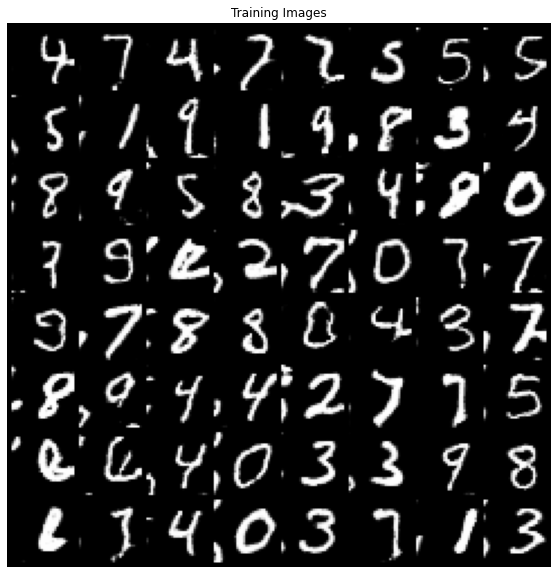

Epoch: [17][0/1093]	generator_loss: 0.9415 (0.9415)	discriminator_loss: 0.5936 (0.5936)	
Epoch: [17][200/1093]	generator_loss: 0.9847 (1.0319)	discriminator_loss: 0.5626 (0.5638)	
Epoch: [17][400/1093]	generator_loss: 1.0109 (1.0352)	discriminator_loss: 0.5949 (0.5652)	
Epoch: [17][600/1093]	generator_loss: 1.0195 (1.0335)	discriminator_loss: 0.5642 (0.5647)	
Epoch: [17][800/1093]	generator_loss: 1.1240 (1.0321)	discriminator_loss: 0.5833 (0.5656)	
Epoch: [17][1000/1093]	generator_loss: 0.9041 (1.0277)	discriminator_loss: 0.5768 (0.5669)	


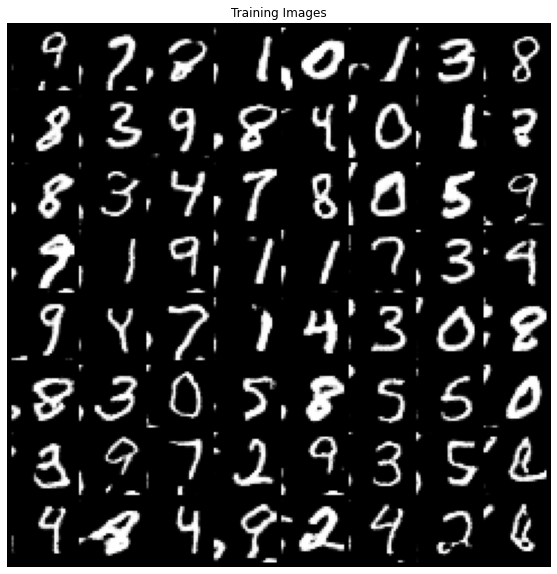

Epoch: [18][0/1093]	generator_loss: 1.3370 (1.3370)	discriminator_loss: 0.5379 (0.5379)	
Epoch: [18][200/1093]	generator_loss: 1.3161 (1.0435)	discriminator_loss: 0.6038 (0.5723)	
Epoch: [18][400/1093]	generator_loss: 0.9917 (1.0337)	discriminator_loss: 0.5477 (0.5700)	
Epoch: [18][600/1093]	generator_loss: 1.0188 (1.0387)	discriminator_loss: 0.5374 (0.5707)	
Epoch: [18][800/1093]	generator_loss: 0.9734 (1.0352)	discriminator_loss: 0.5975 (0.5714)	
Epoch: [18][1000/1093]	generator_loss: 0.8552 (1.0347)	discriminator_loss: 0.6050 (0.5719)	


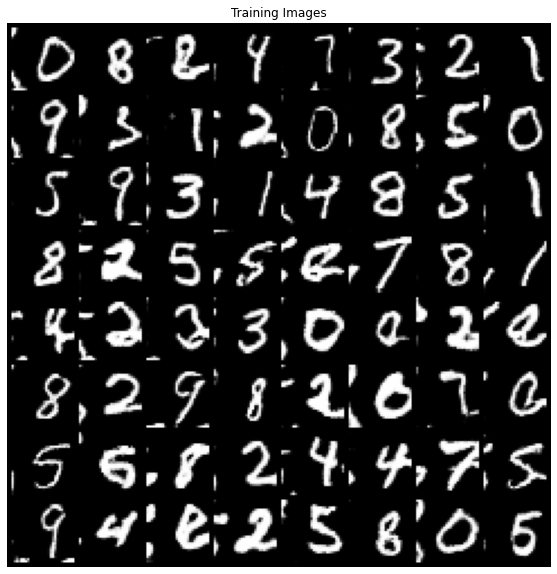

Epoch: [19][0/1093]	generator_loss: 1.0625 (1.0625)	discriminator_loss: 0.5575 (0.5575)	
Epoch: [19][200/1093]	generator_loss: 1.0602 (1.0301)	discriminator_loss: 0.5623 (0.5662)	
Epoch: [19][400/1093]	generator_loss: 1.1032 (1.0298)	discriminator_loss: 0.6365 (0.5693)	
Epoch: [19][600/1093]	generator_loss: 0.9167 (1.0280)	discriminator_loss: 0.5477 (0.5704)	
Epoch: [19][800/1093]	generator_loss: 0.9172 (1.0245)	discriminator_loss: 0.5481 (0.5732)	
Epoch: [19][1000/1093]	generator_loss: 1.0380 (1.0235)	discriminator_loss: 0.5992 (0.5745)	


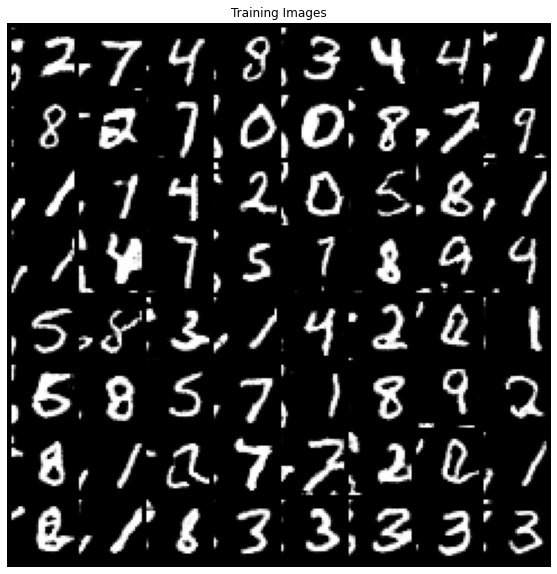

In [14]:
for epoch in range(epochs) :
    generator.train()
    discriminator.train()
    
    gen_loss_tracker = AverageMeter()
    disc_loss_tracker = AverageMeter()
    
    for i, (images, labels) in enumerate(train_loader):
        labels = F.one_hot(labels, num_classes=num_classes)
        images = images.to(device)
        labels = labels.to(device)
        
        random_latent_vectors = torch.randn(batch_size, latent_dim)
        random_latent_vectors = random_latent_vectors.to(device)
    
        generated_images = generator(random_latent_vectors, labels)
        predictions_fake, _ = discriminator(generated_images, labels)
        predictions_real, _ = discriminator(images, labels)
        combined_predictions = torch.cat(
            (predictions_fake, predictions_real), 0
        )
        
        gt_labels = torch.cat(
            (torch.ones(batch_size, 1), torch.zeros(batch_size, 1)), 0
        ).to(device)
        
        d_loss = criterion(combined_predictions, gt_labels)
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        random_latent_vectors = torch.randn(batch_size, latent_dim).to(device)
        
        generated_images = generator(random_latent_vectors, labels)
        predictions_fake_to_real, tmp = discriminator(generated_images, labels)
    
        misleading_labels = torch.zeros(batch_size, 1).to(device)
        
        g_loss = criterion(predictions_fake_to_real, misleading_labels)
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
        disc_loss_tracker.update(np.mean(d_loss.item()))
        gen_loss_tracker.update(np.mean(g_loss.item()))
        if i % 200 == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'generator_loss: {gen_loss_tracker.val:.4f} ({gen_loss_tracker.avg:.4f})\t'
                  'discriminator_loss: {disc_loss_tracker.val:.4f} ({disc_loss_tracker.avg:.4f})\t'
                  .format(epoch, i, len(train_loader),
                          gen_loss_tracker=gen_loss_tracker,
                          disc_loss_tracker=disc_loss_tracker))
            

    plt.figure(figsize=(10,10)) 
    plt.axis("off") 
    plt.title("Training Images")
    plt.imshow(np.transpose(vutils.make_grid(generated_images[:64].detach().to('cpu'), 
                                             padding=2, normalize=True).cpu(),(1,2,0)))
    plt.show()

In [15]:
tmp[0,1:,0,0]

tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0',
       grad_fn=<SelectBackward>)

In [28]:
tmp[0,1,:,:]

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [17]:
num_interpolation = 9
interpolation_noise = torch.randn(1, latent_dim)
interpolation_noise = torch.repeat_interleave(interpolation_noise, num_interpolation)
interpolation_noise = torch.reshape(interpolation_noise, (num_interpolation, latent_dim))
interpolation_noise = interpolation_noise.to(device)

def interpolate_class(first_number, second_number):
    # Convert the start and end labels to one-hot encoded vectors.
    first_label = F.one_hot(torch.tensor([first_number]), num_classes)
    second_label = F.one_hot(torch.tensor([second_number]), num_classes)

    # Calculate the interpolation vector between the two labels.
    percent_second_label = torch.linspace(0, 1, num_interpolation)[:, None]
    interpolation_labels = (
        first_label * (1 - percent_second_label) + second_label * percent_second_label
    ).to(device)

    fake = generator(interpolation_noise, interpolation_labels)
    return fake
start_class = 3  
end_class = 8  

fake_images = interpolate_class(start_class, end_class)

In [19]:
images.shape, labels.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64, 10]))

In [20]:
gen_label = F.one_hot(torch.randint(0,10,(batch_size,))).to(device)
gen_label.shape

torch.Size([64, 10])

In [29]:
(labels*gen_label).sum()

tensor(8, device='cuda:0')

In [22]:
nn.Sigmoid()(discriminator(images, labels)[0]).mean()

tensor(0.3848, device='cuda:0', grad_fn=<MeanBackward0>)

In [23]:
nn.Sigmoid()(discriminator(images, gen_label)[0]).mean()

tensor(0.4748, device='cuda:0', grad_fn=<MeanBackward0>)

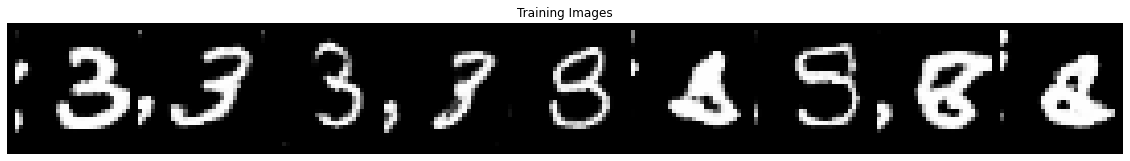

In [18]:
plt.figure(figsize=(20,20)) 
plt.axis("off") 
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(fake_images.detach().to('cpu'), nrow=10,
                                         padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()